# 2D_TMDでの線形・非線形応答

In [2]:
using Distributed
addprocs(10)

10-element Vector{Int64}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11

In [3]:
#Parm(t_i, a_u, a_d, Pr, mu, eta, T, hx, hy, hz, K_SIZE, W_MAX, W_SIZE)
@everywhere struct Parm
    t_i::Float64
    a_u::Float64
    a_d::Float64
    Pr::Float64
    mu::Float64
    eta::Float64
    T::Float64
    hx::Float64
    hy::Float64
    hz::Float64
    K_SIZE::Int
    W_MAX::Float64
    W_SIZE::Int
end

@everywhere mutable struct Hamiltonian
    Hk::Array{ComplexF64,2}
    Vx::Array{ComplexF64,2}
    Vy::Array{ComplexF64,2}
    Vxx::Array{ComplexF64,2}
    Vxy::Array{ComplexF64,2}
    Vyy::Array{ComplexF64,2}
    E::Array{ComplexF64,1}
end

@everywhere mutable struct Green
    GR::Array{ComplexF64,2}
    GA::Array{ComplexF64,2}
    GRmA::Array{ComplexF64,2}
    dGR::Array{ComplexF64,2}
    dGA::Array{ComplexF64,2}
    ddGR::Array{ComplexF64,2}
end

In [4]:
@everywhere using LinearAlgebra

In [5]:
@everywhere function Gk(w::Float64, p::Parm, Ham::Hamiltonian)
    #Green関数のinverse
    GR0::Array{ComplexF64,2} = -Ham.Hk + Matrix{Complex{Float64}}(w*I,2,2) + p.eta*Matrix{Complex{Float64}}(1.0im*I,2,2)

    GR::Array{ComplexF64,2} = inv(GR0)
    GA::Array{ComplexF64,2} = GR'
    GRmA::Array{ComplexF64,2} = GR - GA
    dGR::Array{ComplexF64,2} = - GR * GR
    dGA::Array{ComplexF64,2} = - GA * GA
    ddGR::Array{ComplexF64,2} = 2.0* GR * GR * GR
    
    return GR, GA, GRmA, dGR, dGA, ddGR
end

@everywhere a1 = [1.0, 0.0]
@everywhere a2 = [-0.5, sqrt(3.0)/2]
@everywhere a3 = [0.5, sqrt(3.0)/2]
@everywhere sigma = [[1.0 0.0; 0.0 1.0], [0.0 1.0; 1.0 0.0], [0.0 -1.0im; 1.0im 0.0], [1.0 0.0; 0.0 -1.0]]


@everywhere function HandV(k0::NTuple{2, Float64},p::Parm)
    k = [k0[1], k0[2]]
    eps::Float64 = 2.0p.t_i*(p.Pr*cos(k'*a1) + cos(k'*a2) + cos(k'*a3)) + p.mu
    g_x::Float64 = p.a_u*(sin(k'*a3) + sin(k'*a2))/2 - p.hx
    g_y::Float64 = -p.a_u * (sin(k'*a1) + (sin(k'*a3) - sin(k'*a2))/2)/sqrt(3.0) - p.hy
    g_z::Float64 = 2p.a_d*(sin(k'*a1) + sin(k'*a2) - sin(k'*a3))/(3.0*sqrt(3.0)) - p.hz
    gg = [eps, g_x, g_y, g_z]
    H::Array{ComplexF64,2} =  gg' * sigma

    eps_vx::Float64 = 2.0p.t_i*(-p.Pr*sin(k'*a1) + 0.5sin(k'*a2) - 0.5sin(k'*a3))
    gx_vx::Float64 = p.a_u*(cos(k'*a3) - cos(k'*a2))/4 
    gy_vx::Float64 = -p.a_u * (cos(k'*a1) + 0.5*(cos(k'*a3) + cos(k'*a2))/2)/sqrt(3.0)
    gz_vx::Float64 = 2p.a_d*(cos(k'*a1) - 0.5cos(k'*a2) - 0.5cos(k'*a3))/(3.0*sqrt(3.0))
    gg_x = [eps_vx, gx_vx, gy_vx, gz_vx]
    Vx::Array{ComplexF64,2} = gg_x' * sigma

    eps_vy::Float64 = sqrt(3.0)*p.t_i*(-sin(k'*a2) - sin(k'*a3))
    gx_vy::Float64 = sqrt(3.0)*p.a_u*(cos(k'*a3) + cos(k'*a2))/4 
    gy_vy::Float64 = -p.a_u * ((cos(k'*a3) - cos(k'*a2))/4)
    gz_vy::Float64 = p.a_d*(cos(k'*a2) - cos(k'*a3))/(3.0)
    gg_y = [eps_vy, gx_vy, gy_vy, gz_vy]
    Vy::Array{ComplexF64,2} = gg_y' * sigma

    eps_vxx::Float64 = 2.0p.t_i*(-p.Pr*cos(k'*a1) - 0.25cos(k'*a2) - 0.25cos(k'*a3))
    gx_vxx::Float64 = p.a_u*(-sin(k'*a3) - sin(k'*a2))/8 
    gy_vxx::Float64 = -p.a_u * (-sin(k'*a1) + 0.25*(-sin(k'*a3) + sin(k'*a2))/2)/sqrt(3.0)
    gz_vxx::Float64 = 2p.a_d*(-sin(k'*a1) - 0.25sin(k'*a2) + 0.25sin(k'*a3))/(3.0*sqrt(3.0))
    gg_xx = [eps_vxx, gx_vxx, gy_vxx, gz_vxx]
    Vxx::Array{ComplexF64,2} = gg_xx' * sigma
    
    eps_vxy::Float64 = sqrt(3.0)*p.t_i*(cos(k'*a2) - cos(k'*a3))/2
    gx_vxy::Float64 = sqrt(3.0)*p.a_u*(-sin(k'*a3) + sin(k'*a2))/8 
    gy_vxy::Float64 = -p.a_u * ((-sin(k'*a3) - sin(k'*a2))/8)
    gz_vxy::Float64 = p.a_d*(sin(k'*a2) + sin(k'*a3))/(6.0)
    gg_xy = [eps_vxy, gx_vxy, gy_vxy, gz_vxy]
    Vxy::Array{ComplexF64,2} = gg_xy' * sigma

    eps_vyy::Float64 = 1.5*p.t_i*(-cos(k'*a2) - cos(k'*a3))
    gx_vyy::Float64 = 3.0*p.a_u*(-sin(k'*a3) - sin(k'*a2))/8 
    gy_vyy::Float64 = -p.a_u * sqrt(3.0) * ((-sin(k'*a3) + sin(k'*a2))/8)
    gz_vyy::Float64 = p.a_d*(-sin(k'*a2) + sin(k'*a3))/(2.0*sqrt(3.0))
    gg_yy = [eps_vyy, gx_vyy, gy_vyy, gz_vyy]
    Vyy::Array{ComplexF64,2} = gg_yy' * sigma

    E::Array{ComplexF64,1} = zeros(2)

    return H, Vx, Vy, Vxx, Vxy, Vyy, E 
end

@everywhere function HV_BI(H::Hamiltonian)

    H.E, BI::Array{ComplexF64,2} = eigen(H.Hk)
    H.Hk = [H.E[1] 0.0; 0.0 H.E[2]]
    Vx_BI::Array{ComplexF64,2} = BI' * H.Vx * BI
    Vy_BI::Array{ComplexF64,2} = BI' * H.Vy * BI
    Vxx_BI::Array{ComplexF64,2} = BI' * H.Vxx * BI
    Vxy_BI::Array{ComplexF64,2} = BI' * H.Vxy * BI
    Vyy_BI::Array{ComplexF64,2} = BI' * H.Vyy * BI
    

    H.Vx = Vx_BI
    H.Vy = Vy_BI
    H.Vxx = Vxx_BI
    H.Vxy = Vxy_BI
    H.Vyy = Vyy_BI
end

In [6]:
@everywhere f(e::Float64,T::Float64) = 1.0/(1.0+exp(e/T))
@everywhere df(e::Float64,T::Float64) = -1.0/(1.0+exp(e/T))/(1.0+exp(-e/T))/T

@everywhere f(e::ComplexF64,T::Float64) = 1.0/(1.0+exp(e/T))
@everywhere df(e::ComplexF64,T::Float64) = -1.0/(1.0+exp(e/T))/(1.0+exp(-e/T))/T

@everywhere function Green_YY_BI(p::Parm, H::Hamiltonian)
    
    Drude::Float64 = 0.0
    Drude0::Float64 = 0.0
    BC::Float64 = 0.0
    dQM::Float64 = 0.0
    app_QM::Float64 = 0.0
    
    #HV_BI(H)

    for i = 1:2
        Drude += -real(H.Vy[i,i]*H.Vy[i,i])*real(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta)
        Drude0 += -real(H.Vy[i,i]*H.Vy[i,i])*real(df(H.E[i], p.T))/(2.0p.eta)
        #BC += 2.0*imag(H.Vy[i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))*real(f(H.E[i]+1.0im*p.eta, p.T))
        #dQM += 2.0*real(H.Vy[i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))*imag(f(H.E[i]+1.0im*p.eta, p.T))
        BC += 2.0*imag(H.Vy[i,3-i]*H.Vy[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*real(f(H.E[i]+1.0im*p.eta, p.T)/(H.E[i]-H.E[3-i]+2.0im*p.eta))
        dQM += 2.0*real(H.Vy[i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)))*imag(f(H.E[i]+1.0im*p.eta, p.T)/(H.E[i]-H.E[3-i]+2.0im*p.eta))
        app_QM += 2.0*p.eta*real(H.Vy[i,3-i]*H.Vy[3-i,i])/((H.E[i]-H.E[3-i])^2+4.0*p.eta^2)*(-df(H.E[i], p.T))
    end
    return Drude, Drude0, BC, dQM, app_QM
end

@everywhere function Green_YY2_BI(p::Parm, H::Hamiltonian)
    
    Drude::Float64 = 0.0
    Drude0::Float64 = 0.0
    BC::Float64 = 0.0
    dQM::Float64 = 0.0
    app_QM::Float64 = 0.0
    
    #HV_BI(H)

    for i = 1:2
        Drude += -real(H.Vy[i,i]*H.Vy[i,i])*real(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta)
        Drude0 += -real(H.Vy[i,i]*H.Vy[i,i])*real(df(H.E[i], p.T))/(2.0p.eta)
        BC += imag(H.Vy[i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)))*real(df(H.E[i]+1.0im*p.eta, p.T))
        dQM += real(H.Vy[i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)))*imag(df(H.E[i]+1.0im*p.eta, p.T))
        app_QM += 2.0*p.eta*real(H.Vy[i,3-i]*H.Vy[3-i,i])/((H.E[i]-H.E[3-i])^2+4.0*p.eta^2)*(-df(H.E[i], p.T))
    end
    return Drude, Drude0, BC, dQM, app_QM
end

@everywhere function Green_DC_2D(p::Parm, H::Hamiltonian)
    YY::Float64 = 0.0
    #dw::Float64 = p.W_MAX/p.W_SIZE/pi
    mi = minimum([p.W_MAX,12p.T])
    dw::Float64 = mi/p.W_SIZE/pi
    for w in collect(-mi:2.0mi/p.W_SIZE:mi)
        #range(-p.W_MAX, p.W_MAX, length=p.W_SIZE)
        G = Green(Gk(w,p,H)...)
        YY += -real(tr(H.Vy*G.GR*H.Vy*G.GA))*df(w,p.T)
        #ZZ += -2.0real(tr(H.Vz*G.dGR*H.Vz*G.GR))*f(w,p.T)
    end
    return dw*YY
end

@everywhere function Green_DC_BI(p::Parm, H::Hamiltonian)
    DrG::Float64 = 0.0
    BCG::Float64 = 0.0
    #dw::Float64 = p.W_MAX/p.W_SIZE/pi
    mi = minimum([p.W_MAX,12p.T])
    dw::Float64 = mi/p.W_SIZE/pi
    for w in collect(-mi:2.0mi/p.W_SIZE:mi)
        #range(-p.W_MAX, p.W_MAX, length=p.W_SIZE)
        G = Green(Gk(w,p,H)...)
        for i in 1:2
            DrG += real(H.Vy[i,i]*G.GR[i,i]*H.Vy[i,i]*G.GRmA[i,i])*df(w,p.T)
            BCG += real(H.Vy[i,3-i]*G.GR[3-i,3-i]*H.Vy[3-i,i]*G.GRmA[i,i])*df(w,p.T)
        end
        #ZZ += -2.0real(tr(H.Vz*G.dGR*H.Vz*G.GR))*f(w,p.T)
    end
    return dw*DrG, dw*BCG
end

@everywhere function Green_YYY_BI(p::Parm, H::Hamiltonian)
    
    Drude::Float64 = 0.0
    BCD::Float64 = 0.0
    sQMD::Float64 = 0.0
    dQMD::Float64 = 0.0
    Inter::Float64 = 0.0
    dInter::Float64 = 0.0

    #HV_BI(H)

    for i = 1:2
        Drude += 2.0*real(2.0*H.Vy[i,i]*(H.Vy[i,i]*H.Vy[i,i]*imag(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta) + H.Vy[i,3-i]*H.Vy[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta)*real(df(H.E[i]+1.0im*p.eta, p.T)) + H.Vyy[i,i]*real(df(H.E[i]+1.0im*p.eta, p.T))))/((2.0p.eta)^2)

        #Drude += 2.0*real(2.0*H.Vy[i,i]*H.Vy[i,i]*H.Vy[i,i])*imag(df(H.E[i]+1.0im*p.eta, p.T))/((2.0p.eta)^3)
        #BCD += 2.0*real(2.0*H.Vy[i,i]* H.Vy[i,3-i]*H.Vy[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta)*real(df(H.E[i]+1.0im*p.eta, p.T)))/((2.0p.eta)^2)
        #sQMD += 2.0*real(2.0*H.Vy[i,i]*H.Vyy[i,i]*real(df(H.E[i]+1.0im*p.eta, p.T)))/((2.0p.eta)^2)
        BCD += -4.0*imag(H.Vy[i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))*real(H.Vy[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta)
        sQMD += -2.0*imag(2.0*H.Vy[i,i]*H.Vy[i,3-i]*H.Vy[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*imag(df(H.E[i]+1.0im*p.eta, p.T))/((2.0p.eta)^2)
        dQMD += -4.0*real(H.Vy[i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))*imag(H.Vy[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta)
        Inter += -2.0real(H.Vy[i,3-i]*(2.0*H.Vy[3-i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3) + H.Vyy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2)))*real(df(H.E[i]+1.0im*p.eta, p.T))
        dInter += 2.0imag(H.Vy[i,3-i]*(2.0*H.Vy[3-i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3) + H.Vyy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2)))*imag(df(H.E[i]+1.0im*p.eta, p.T))
        #Drude += -2.0real(H.Vy[i,3-i]*H.Vyy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))*real(df(H.E[i]+1.0im*p.eta, p.T))
    end
    #=
    for w = collect(Float64,-p.W_MAX:2*p.W_MAX/p.W_SIZE:p.W_MAX)
        G = Green(Green_BI(w,p,H)...)
    end=#
    return Drude, BCD, sQMD, dQMD, Inter, dInter
end
@everywhere function Green_YXX_BI(p::Parm, H::Hamiltonian)
    
    Drude::Float64 = 0.0
    BCD::Float64 = 0.0
    sQMD::Float64 = 0.0
    dQMD::Float64 = 0.0
    Inter::Float64 = 0.0
    dInter::Float64 = 0.0

    #HV_BI(H)

    for i = 1:2
        #Drude += 2.0*real(2.0*H.Vy[i,i]*(H.Vx[i,i]*H.Vx[i,i]*imag(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta) + H.Vx[i,3-i]*H.Vx[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta)*real(df(H.E[i]+1.0im*p.eta, p.T)) + H.Vxx[i,i]*real(df(H.E[i]+1.0im*p.eta, p.T))))/((2.0p.eta)^2)


        #Drude += 2.0*real(2.0*H.Vy[i,i]*H.Vy[i,i]*H.Vy[i,i])*imag(df(H.E[i]+1.0im*p.eta, p.T))/((2.0p.eta)^3)
        #BCD += 2.0*real(2.0*H.Vy[i,i]* H.Vy[i,3-i]*H.Vy[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta)*real(df(H.E[i]+1.0im*p.eta, p.T)))/((2.0p.eta)^2)
        #sQMD += 2.0*real(2.0*H.Vy[i,i]*H.Vyy[i,i]*real(df(H.E[i]+1.0im*p.eta, p.T)))/((2.0p.eta)^2)
        BCD += -2.0*imag(H.Vy[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))real(H.Vx[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        sQMD += -2.0*imag(2.0*H.Vy[i,i]*H.Vx[i,3-i]*H.Vx[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*imag(df(H.E[i]+1.0im*p.eta, p.T))/((2.0p.eta)^2)
        dQMD += -2.0*real(H.Vy[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))*imag(H.Vx[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        Inter += -2.0real(H.Vy[i,3-i]*(2.0*H.Vx[3-i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3) + H.Vxx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2)))*real(df(H.E[i]+1.0im*p.eta, p.T))
        dInter += 2.0imag(H.Vy[i,3-i]*(2.0*H.Vx[3-i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3) + H.Vxx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2)))*imag(df(H.E[i]+1.0im*p.eta, p.T))
        Drude += -2.0real(H.Vy[i,3-i]*H.Vxx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))*real(df(H.E[i]+1.0im*p.eta, p.T))
    end
    #=
    for w = collect(Float64,-p.W_MAX:2*p.W_MAX/p.W_SIZE:p.W_MAX)
        G = Green(Green_BI(w,p,H)...)
    end=#
    return Drude, BCD, sQMD, dQMD, Inter, dInter
end

@everywhere function Green_XXX_BI(p::Parm, H::Hamiltonian)
    
    Drude::Float64 = 0.0
    BCD::Float64 = 0.0
    sQMD::Float64 = 0.0
    dQMD::Float64 = 0.0
    Inter::Float64 = 0.0
    dInter::Float64 = 0.0

    #HV_BI(H)

    for i = 1:2
        Drude += 2.0*real(2.0*H.Vx[i,i]*(H.Vx[i,i]*H.Vx[i,i]*imag(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta) + H.Vx[i,3-i]*H.Vx[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta)*real(df(H.E[i]+1.0im*p.eta, p.T)) + H.Vxx[i,i]*real(df(H.E[i]+1.0im*p.eta, p.T))))/((2.0p.eta)^2)

        #Drude += 2.0*real(2.0*H.Vx[i,i]*H.Vx[i,i]*H.Vx[i,i])*imag(df(H.E[i]+1.0im*p.eta, p.T))/((2.0p.eta)^3)
        #BCD += 2.0*real(2.0*H.Vx[i,i]* H.Vx[i,3-i]*H.Vx[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta)*real(df(H.E[i]+1.0im*p.eta, p.T)))/((2.0p.eta)^2)
        #sQMD += 2.0*real(2.0*H.Vx[i,i]*H.Vxx[i,i]*real(df(H.E[i]+1.0im*p.eta, p.T)))/((2.0p.eta)^2)
        BCD += -4.0*imag(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))real(H.Vx[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        sQMD += -2.0*imag(2.0*H.Vx[i,i]*H.Vx[i,3-i]*H.Vx[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*imag(df(H.E[i]+1.0im*p.eta, p.T))/((2.0p.eta)^2)
        dQMD += -4.0*real(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))*imag(H.Vx[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        Inter += -2.0real(H.Vx[i,3-i]*(2.0*H.Vx[3-i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3) + H.Vxx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2)))*real(df(H.E[i]+1.0im*p.eta, p.T))
        dInter += 2.0imag(H.Vx[i,3-i]*(2.0*H.Vx[3-i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3) + H.Vxx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2)))*imag(df(H.E[i]+1.0im*p.eta, p.T))
    end
    #=
    for w = collect(Float64,-p.W_MAX:2*p.W_MAX/p.W_SIZE:p.W_MAX)
        G = Green(Green_BI(w,p,H)...)
    end=#
    return Drude, BCD, sQMD, dQMD, Inter, dInter
end

@everywhere function Green_YYY(p::Parm, H::Hamiltonian)
    G0::Float64 = 0.0
    mi = minimum([p.W_MAX,12p.T])
    dw::Float64 = mi/p.W_SIZE/pi
    for w in collect(-mi:2.0mi/p.W_SIZE:mi)
        G = Green(Gk(w,p,H)...)
        G0 += 2.0imag(tr(H.Vy*G.dGR*(2.0*H.Vy*G.GR*H.Vy + H.Vyy)*G.GRmA)*df(w,p.T))
    end
    return dw*G0
end

@everywhere function Green_YYY_sea(p::Parm, H::Hamiltonian)
    G0::Float64 = 0.0
    #mi = minimum([p.W_MAX,12p.T])
    dw::Float64 = (p.W_MAX+10.0p.T)/p.W_SIZE
    for w in collect(-p.W_MAX:dw:10.0p.T)
        G = Green(Gk(w,p,H)...)
        G0 += -2.0imag(tr(H.Vy*G.dGR*(H.Vyy +2.0*H.Vy*G.GR*H.Vy)*G.dGR))*f(w,p.T)
        #G0 += -2.0imag(tr(H.Vy*G.ddGR*H.Vyy*G.GRmA)*f(w,p.T))
    end
    return dw*G0/(2pi)
end

@everywhere function Green_YXX(p::Parm, H::Hamiltonian)
    G0::Float64 = 0.0
    mi = minimum([p.W_MAX,12p.T])
    dw::Float64 = mi/p.W_SIZE/pi
    for w in collect(-mi:2.0mi/p.W_SIZE:mi)
        G = Green(Gk(w,p,H)...)
        G0 += 2.0imag(tr(H.Vy*G.dGR*(2.0*H.Vx*G.GR*H.Vx + H.Vxx)*G.GRmA)*df(w,p.T))
    end
    return dw*G0
end

@everywhere function Green_YXX_sea(p::Parm, H::Hamiltonian)
    G0::Float64 = 0.0
    #mi = minimum([p.W_MAX,12p.T])
    dw::Float64 = (p.W_MAX+10.0p.T)/p.W_SIZE/(2.0pi)
    for w in collect(-p.W_MAX:2pi*dw:10.0p.T)
        G = Green(Gk(w,p,H)...)
        G0 += -2.0imag(tr(H.Vy*G.dGR*(H.Vxx +2.0*H.Vx*G.GR*H.Vx)*G.dGR))*f(w,p.T)
    end
    return dw*G0
end

@everywhere function Green_YXX_seaBI(p::Parm, H::Hamiltonian)
    Dr0::Float64 = 0.0
    Bc0::Float64 = 0.0
    Int0::Float64 = 0.0
    #mi = minimum([p.W_MAX,12p.T])
    dw::Float64 = (p.W_MAX+10.0p.T)/p.W_SIZE/(2.0pi)
    for w in collect(-p.W_MAX:2pi*dw:10.0p.T)
        #G = Green(Gk(w,p,H)...)
        for i in 1:2
            Dr0 += imag(2.0H.Vy[i,i]*(H.Vxx[i,i]+ 2.0*H.Vx[i,i]*H.Vx[i,i]/(w-H.E[i]+p.eta))/(w-H.E[i]+p.eta)^4)*f(w,p.T)
            Dr0 += imag(2.0H.Vy[i,i]*2.0*H.Vx[i,3-i]*H.Vx[3-i,i]/(w-H.E[3-i]+p.eta)/(w-H.E[i]+p.eta)^4)*f(w,p.T)
            Bc0 += 4.0imag(H.Vy[i,3-i]*H.Vx[3-i,i]*H.Vx[i,i]/(w-H.E[3-i]+p.eta)^2/(w-H.E[i]+p.eta)^3)*f(w,p.T)
            Int0 += 4.0imag(H.Vy[i,3-i]*H.Vx[3-i,i]*H.Vx[3-i,3-i]/(w-H.E[3-i]+p.eta)^3/(w-H.E[i]+p.eta)^2)*f(w,p.T)
            Int0 += 2.0imag(H.Vy[i,3-i]*H.Vxx[3-i,i]/(w-H.E[3-i]+p.eta)^2/(w-H.E[i]+p.eta)^2)*f(w,p.T)
        end
    end
    return dw*Dr0, dw*Bc0, dw*Int0
end

In [243]:
p_test = Parm(0.5, 0.08, 0.06, 0.7, 0.7, 0.02, 0.02, 0.05, 0.0, 0.0, 100, 3.5, 3000)
k_test = (pi/3, 1.0)
H_test = Hamiltonian(HandV(k_test,p_test)...)
g1_sur = Green_YYY(p_test,H_test)
g1_sea = Green_YYY_sea(p_test,H_test)
println(g1_sur)
println(g1_sea)

k_test = (-pi/3, -1.0)
H_test = Hamiltonian(HandV(k_test,p_test)...)
g2_sur = Green_YYY(p_test,H_test)
g2_sea = Green_YYY_sea(p_test,H_test)
println(g1_sur+g2_sur)
println(g1_sea+g2_sea)

-0.002699077372624174
-0.001331418311537977
0.00011420237927194012
5.699760271759245e-5


## Dispersion

In [13]:
K_S = 100
#q = zeros{Float64,1}(4*K_S)
E1 = zeros(4*K_S)
E2 = zeros(4*K_S)
p_test = Parm(0.5, 0.08, 0.06, 0.7, 0.0, 0.02, 0.02, 0.0, 0.0, 0.0, K_S, 3.0, 800)

for K0 in 1:K_S
    KK = 4pi/3*K0/K_S
    k = 4pi/3*a1 + KK*a2
    kk = (k[1], k[2])
    H = Hamiltonian(HandV(kk,p_test)...)
    e, v = eigen(H.Hk)
    E1[K0] = real(e[1])
    E2[K0] = real(e[2])
end

for K0 in 1:K_S
    KK = 2pi/3*K0/K_S
    k = 4pi/3*a3 - KK*a1
    kk = (k[1], k[2])
    H = Hamiltonian(HandV(kk,p_test)...)
    e, v = eigen(H.Hk)
    E1[K0+K_S] = real(e[1])
    E2[K0+K_S] = real(e[2])
end

for K0 in 1:K_S
    KK = 4pi/3*K0/K_S
    k = 4pi/3*a3 -2pi/3*a1 + KK*(0.5*a1 - a3) 
    kk = (k[1], k[2])
    H = Hamiltonian(HandV(kk,p_test)...)
    e, v = eigen(H.Hk)
    E1[K0+2K_S] = real(e[1])
    E2[K0+2K_S] = real(e[2])
    #println(kk)
end
for K0 in 1:K_S
    #KK = 4pi/3*K0/K_S
    #k = KK*a1
    #KK = 2pi/3*K0/K_S
    KK = 4pi/3*K0/K_S
    #k = KK*(a1 + a3)
    k = KK*(a1)
    kk = (k[1], k[2])
    H = Hamiltonian(HandV(kk,p_test)...)
    e, v = eigen(H.Hk)
    E1[K0+3K_S] = real(e[1])
    E2[K0+3K_S] = real(e[2])
end


In [8]:
using Plots
Plots.scalefontsizes(1.4)

In [61]:
w0 = collect(-0.2:0.01:0.2)
eta1 = 0.01
eta2 = 0.02
T00 = 0.02
ref = real(f.(1.0im*eta1.+w0,T00))
imf = imag(f.(1.0im*eta1.+w0,T00))
app_re = f.(w0,T00)
app_im = eta1*df.(w0,T00)

pf = plot(w0,ref,xlabel="ω",label="Re[f]",title="T=0.02, η=0.01", linewidth=6.0, gridwidth=2.0)
pf = plot!(w0,app_re, linewidth=4.0,label="f0")
pf = plot!(w0,imf, linewidth=6.0,label="im[f]")
pf = plot!(w0,app_im, linewidth=4.0, color=:red,label="η*df0")
savefig(pf,"./df_app1.png")

In [78]:
w0 = collect(-0.5:0.01:0.5)
eta1 = 0.01
eta2 = 0.1
en = 0.1
T00 = 0.02
df00 = real(-df.(w0,T00))
Aw = -imag(1 ./(- en + 1.0im*eta1 .+ w0))/pi

pf = plot(w0,df00,xlabel="ω",label="-df/dω",title="T=0.02, η=0.01", linewidth=6.0, gridwidth=2.0)
pf = plot!(w0,Aw, linewidth=6.0,label="A(ω)")
savefig(pf,"./sm1.png")

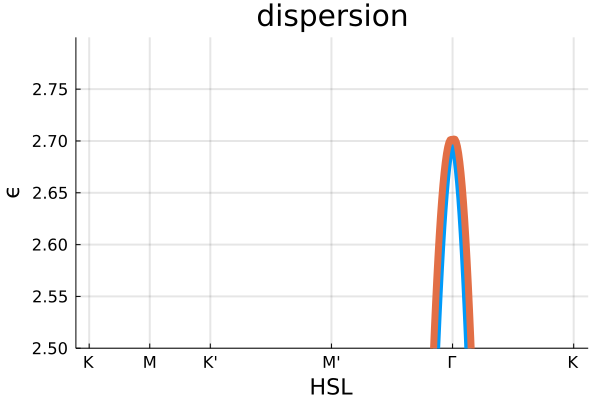

In [29]:
pw = plot(E1,xticks=([0,50,100,200,300,400],["K", "M", "K'", "M'", "Γ","K"]),xlabel="HSL",ylabel="ϵ",label="e1",title="dispersion", linewidth=7.0,ylims=(2.5,2.8),legend=nothing, gridwidth=2.0)
pw = plot!(E2, linewidth=7.0)
#savefig(pw,"./dispersion3.png")

In [79]:
test = collect(0:0.1:1)
test[11]

1.0

In [6]:
K_SIZE = 1000
kk = Vector{NTuple{2, Float64}}(undef,0)
dk = 4pi/(3K_SIZE)
dk2 = 2.0/(3*sqrt(3.0)*K_SIZE*K_SIZE)
for i in collect(dk:dk:4pi/3)
    
    for j in collect(0:dk:4pi/3)
        k = j*a1 + i*a2
        push!(kk,(k[1],k[2]))
    end
    
    
    for j in collect(dk:dk:4pi/3)
        if (i+j) < (4pi/3+dk)
            k = -j*a1 + i*a3
            push!(kk,(k[1],k[2]))
        end
    end
end
l = length(kk)

for i in 1:l
    k0 = kk[i]
    k0 = -1 .* k0
    push!(kk,k0)
end

for i in collect(-4pi/3:dk:4pi/3)
    k = i*a1
    push!(kk,(k[1],k[2]))
end

In [9]:
#@everywhere using LinearAlgebra
#using DataFrames
#using CSV
#using Plots
mu0 = [0.9, 1.3]
#collect(1.205:0.05:1.505)

DrudeX_mu = zeros(Float64,length(mu0))
#=
Drude0_mu = zeros(Float64,length(mu0))
BCX_mu = zeros(Float64,length(mu0))
dQMX_mu = zeros(Float64,length(mu0))
app_QM_mu = zeros(Float64,length(mu0))
Green_mu = zeros(Float64,length(mu0))=#
#=
Green_XXX_mu = zeros(Float64,length(mu0))
Green_XXX_sea = zeros(Float64,length(mu0))

Drude_XXX_mu = zeros(Float64,length(mu0))
BCD_XXX_mu = zeros(Float64,length(mu0))
sQMD_XXX_mu = zeros(Float64,length(mu0))
dQMD_XXX_mu = zeros(Float64,length(mu0))
Inter_XXX_mu = zeros(Float64,length(mu0))
dInter_XXX_mu = zeros(Float64,length(mu0))=#
println(length(kk))

for j in 1:length(mu0)
    #=
    Drude_XXX_mu[j]=0.0
    BCD_XXX_mu[j]=0.0
    sQMD_XXX_mu[j]=0.0
    dQMD_XXX_mu[j]=0.0
    Inter_XXX_mu[j]=0.0
    dInter_XXX_mu[j]=0.0=#
    #length(mu0)
    #Parm(t_i, a_u, a_d, Pr, mu, eta, T, hx, hy, hz, K_SIZE, W_MAX, W_SIZE)
    #p = Parm(0.5, 0.08, 0.06, 0.7, 0.7, mu0[j], 0.02, 0.0, 0.0, 0.0, K_SIZE, 3.0, 1000)
    p = Parm(0.5, 0.08, 0.06, 0.7, mu0[j], 0.04, 0.02, 0.0, 0.0, 0.0, K_SIZE, 0.4, 1000)
    #p = Parm(0.5, 0.08, 0.06, 0.7, 0.7, 0.04, 0.06, 0.0, 0.0, 0.0, K_SIZE, 0.5, 1000)
    
    if j == 1
        println("Parm(t_i, a_u, a_d, Pr, mu, eta, T, hx, hy, hz, K_SIZE, W_MAX, W_SIZE)")
        println(p)
    end

    #DrudeX_mu[j], Drude0_mu[j], BCX_mu[j], dQMX_mu[j], app_QM_mu[j], Green_mu[j] 
    #Drude_XXX_mu[j], BCD_XXX_mu[j], sQMD_XXX_mu[j], dQMD_XXX_mu[j], Inter_XXX_mu[j], dInter_XXX_mu[j]
    #Drude_XXX_mu[j], BCD_XXX_mu[j], sQMD_XXX_mu[j], dQMD_XXX_mu[j], Inter_XXX_mu[j], dInter_XXX_mu[j] 
    DrudeX_mu[j] = @distributed (+) for i in 1:length(kk)
    #, Green_XXX_mu[j], Green_XXX_sea[j]
        Hamk = Hamiltonian(HandV(kk[i],p)...)
        #Green = Green_DC_2D(p, Hamk)
        #Green_NL = Green_YYY(p,Hamk)
        
        #Green_NL
        #Green_sea = Green_YYY_sea(p,Hamk)
        #Green_sea = 0.0
        #HV_BI(Hamk)
        #Dr, Dr_0, BC, dQM, app_QM = Green_YY_BI(p,Hamk)
        #Dr2, Dr_02, BC2, dQM2, app_QM2 = Green_YY2_BI(p,Hamk)
        Green_Dr = Green_DC_2D(p, Hamk)
        dk2*Green_Dr
        #HV_BI(Hamk)
        #Drude_XXX_mu[i], BCD_XXX_mu[i], sQMD_XXX_mu[i], dQMD_XXX_mu[i], Inter_XXX_mu[i], dInter_XXX_mu[i] = Green_XXX_BI(p,Hamk)
        #Drude0, BCD0, sQMD0, dQMD0, Inter0, dInter0 = Green_YYY_BI(p,Hamk)
        #if i == 390
        #    println(kk[i])
        #    println(Drude_XXX_mu[i])
        #end
        #[dk2*Drude0, dk2*BCD0, dk2*sQMD0, dk2*dQMD0, dk2*Inter0, dk2*dInter0]
        #, dk2*Green_NL, dk2*Green_sea]
    end
    print("#")
end
println("finish the calculation!")
# headerの名前を(Q,E1,E2)にして、CSVファイル形式を作成


#using DataFrames
#using CSV
#save_data = DataFrame(mu=mu0, Drude=DrudeX_mu, BC=BCX_mu, dQM=dQMX_mu, BC2=app_QM_mu, Green_Dr=Drude0_mu, dQM2=Green_mu)
#「./」で現在の(tutorial.ipynbがある)ディレクトリにファイルを作成の意味、指定すれば別のディレクトリにファイルを作ることも出来る。
#CSV.write("./mudep_etadep_T002_YY.csv", save_data)
#using DataFrames
#using CSV
#save_data2 = DataFrame(mu=mu0, Drude=Drude_XXX_mu, BCD=BCD_XXX_mu, sQMD=sQMD_XXX_mu, dQMD=dQMD_XXX_mu, Inter=Inter_XXX_mu, dInter=dInter_XXX_mu, Green=Green_XXX_mu, Green_sea=Green_XXX_sea)
#CSV.write("./mudep_TRB_eta004_T002_YYY_k_add.csv", save_data2)


#gr()


3003005
Parm(t_i, a_u, a_d, Pr, mu, eta, T, hx, hy, hz, K_SIZE, W_MAX, W_SIZE)
Parm(0.5, 0.08, 0.06, 0.7, 0.9, 0.04, 0.02, 0.0, 0.0, 0.0, 1000, 0.4, 1000)
##finish the calculation!


In [10]:
DrudeX_mu

2-element Vector{Float64}:
 5.934318771211628
 2.134137120078062

Worker 28 terminated.
Worker 20 terminated.Unhandled Task ERROR: IOError: read: connection reset by peer (ECONNRESET)
Stacktrace:
  [1] wait_readnb(x::Sockets.TCPSocket, nb::Int64)
    @ Base .\stream.jl:408
  [2] (::Base.var"#wait_locked#645")(s::Sockets.TCPSocket, buf::IOBuffer, nb::Int64)
    @ Base .\stream.jl:894
  [3] unsafe_read(s::Sockets.TCPSocket, p::Ptr{UInt8}, nb::UInt64)
    @ Base .\stream.jl:900
  [4] unsafe_read
    @ .\io.jl:724 [inlined]
  [5] unsafe_read(s::Sockets.TCPSocket, p::Base.RefValue{NTuple{4, Int64}}, n::Int64)
    @ Base .\io.jl:723
  [6] read!
    @ .\io.jl:725 [inlined]
  [7] deserialize_hdr_raw
    @ C:\Users\Michishita\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Distributed\src\messages.jl:167 [inlined]
  [8] message_handler_loop(r_stream::Sockets.TCPSocket, w_stream::Sockets.TCPSocket, incoming::Bool)
    @ Distributed C:\Users\Michishita\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Distributed\src\process_messages.jl:165


In [10]:
Drude_XXX_mu

18-element Vector{Float64}:
  0.8144213892053784
  0.8372978852596802
  1.1333681036111969
  1.8618500341896365
  2.2831354991554207
  1.7560655656028388
  0.6932102197071082
  0.2047006138132197
  0.25867564792698516
  0.26847916924216264
  0.2529929218558884
  0.16035246422171667
 -0.3744626921666949
 -1.1341144668326812
 -1.2262335760497294
 -0.37074006903706014
  0.43649504243395265
  0.5772213633152008

In [98]:
for i in 1:length(mu0)
    Green_XXX_mu[i] = Green_XXX_mu[i]*dk2
end
save_data2 = DataFrame(mu=mu0, Drude=Drude_XXX_mu, BCD=BCD_XXX_mu, sQMD=sQMD_XXX_mu, dQMD=dQMD_XXX_mu, Inter=Inter_XXX_mu, dInter=dInter_XXX_mu, Green=Green_XXX_mu, Green_sea=Green_XXX_sea)
CSV.write("./mudep_TRB_eta004_T002_YYY_k_add.csv", save_data2)

"./mudep_TRB_eta004_T002_YYY_k_add.csv"

In [101]:
p0 = Parm(0.5, 0.08, 0.06, 0.7, 1.4, 0.04, 0.02, 0.05, 0.0, 0.0, K_SIZE, 3.0, 1000)
GreenX=0.0
GreenX = @distributed (+) for i in 1:length(kk)
    Hamk = Hamiltonian(HandV(kk[i],p0)...)
    #Green = Green_DC_2D(p, Hamk)
    Green_NL = Green_YYY(p0,Hamk)
    dk2*Green_NL
end
println(GreenX)

-0.05862910040550595


In [94]:
using DataFrames
using CSV
save_data2 = DataFrame(mu=mu0, Drude=Drude_XXX_mu, BCD=BCD_XXX_mu, sQMD=sQMD_XXX_mu, dQMD=dQMD_XXX_mu, Inter=Inter_XXX_mu, dInter=dInter_XXX_mu, Green=Green_XXX_mu, Green_sea=Green_XXX_sea)
CSV.write("./mudep_TRB_eta004_T002_YYY_add.csv", save_data2)

"./mudep_TRB_eta004_T002_YYY_add.csv"

In [59]:
println(Green_XXX_mu)

[-0.005295139079268692, -0.010488923544518322, -0.015494192373682455, -0.02023083127484098, -0.024631468531918554]


In [12]:
println(Drude_XXX_mu)

[147.49720931844953, 40.29057924998692, 18.847340189769163, 10.953161543137858, 7.174669832512099, 3.3218077710782192, 1.9303365962064845]


In [10]:
using Plots
Plots.scalefontsizes(1.4)

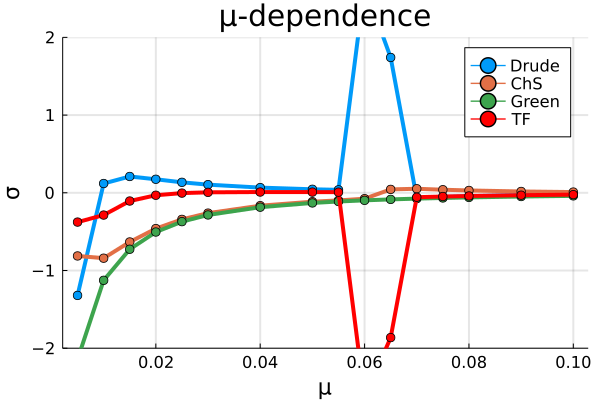

In [29]:
#using Plots
using LaTeXStrings 

px = plot(mu0, -Drude_XXX_mu, label="Drude",xlabel="μ",ylabel="σ",title="μ-dependence", width=4.0, marker=:circle, markersize = 4.8, gridwidth = 2.0, ylims=(-2,2))
#plot!(mu0, sQMD_XXX_mu, label="sQMD", width=2.0, marker=:circle)
#plot!(mu0, -BCD_XXX_mu, label="BCD", width=4.0, marker=:circle, markersize = 4.8)
px = plot!(mu0, -dQMD_XXX_mu-sQMD_XXX_mu, label="ChS", width=4.0, marker=:circle, markersize = 4.8)
#plot!(mu0, -Inter_XXX_mu, label="Inter", width=4.0, marker=:circle, markersize = 4.8)
px = plot!(mu0, Green_XXX_mu, label="Green", width=4.0, marker=:circle, markersize = 4.8)
#plot!(mu0, -dInter_XXX_mu, label="dInter", xlabel="μ",ylabel="σ",title="nonreciprocal conductivity", width=3.0, marker=:circle)
#plot!(mu0, -dInter_XXX_mu, label="dInter", width=4.0, marker=:circle, markersize = 4.8)
px = plot!(mu0, Green_XXX_mu+(Drude_XXX_mu+sQMD_XXX_mu+dQMD_XXX_mu+Inter_XXX_mu+dInter_XXX_mu), label="TF", width=4.0, marker=:circle, color=:red, markersize = 4.8)
#plot!(mu0, Green_XXX_mu+(Inter_XXX_mu), label="TF", width=2.0, marker=:circle, color=:green)

#plot!(mu0, Green_XXX_sea, label="Green_sea", width=4.0, marker=:circle, color=:orange)
#savefig(px,"./etadep_TRB_mu07_NRC_YYY.png")

In [51]:
K_L = 300

Drudek = zeros(Float64,K_L,K_L)
BCDk = zeros(Float64,K_L,K_L)
sQMDk = zeros(Float64,K_L,K_L)
dQMDk = zeros(Float64,K_L,K_L)
Interk = zeros(Float64,K_L,K_L)
dInterk = zeros(Float64,K_L,K_L)
DOS= zeros(Float64,K_L,K_L)

p_test = Parm(0.5, 0.08, 0.06, 0.7, 0.7, 0.006, 0.02, 0.05, 0.0, 0.0, K_L, 3.0, 2000)
for x in 1:K_L
    for y in 1:K_L
        kx = 4pi*x/(3*K_L)
        ky = 4pi*y/(3*K_L)
        k0 = (kx,ky)
        H = Hamiltonian(HandV(k0,p_test)...)
        HV_BI(H)
        DOS[x,y] = -imag(1.0/(H.E[1]+1.0im*p_test.eta)+1.0/(H.E[2]+1.0im*p_test.eta))
        Drudek[x,y], BCDk[x,y], sQMDk[x,y],dQMDk[x,y],Interk[x,y], dInterk[x,y] = Green_YYY_BI(p_test,H)
    end
end

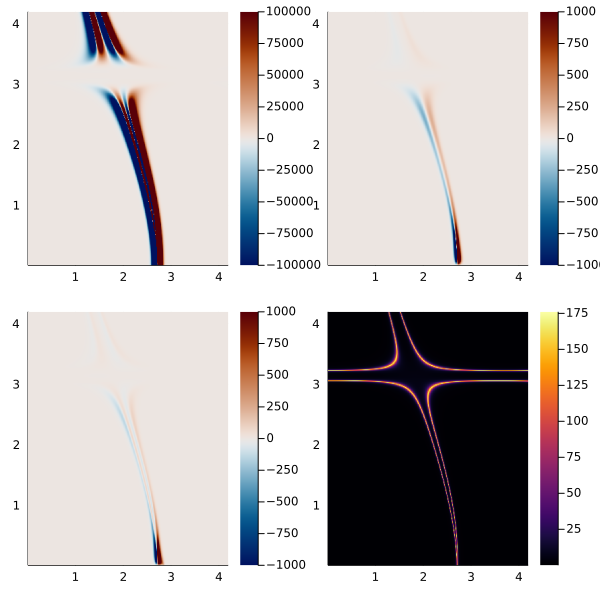

In [52]:
dk00 = 4pi/(3*K_L)
kx = range(dk00,4pi/3, length = K_L)
ky = range(dk00,4pi/3, length = K_L)
p11 = plot(kx,ky,Drudek,st=:heatmap,color=:vik, clims=(-100000,100000))
p22 = plot(kx,ky,BCDk,st=:heatmap,color=:vik, clims=(-1000,1000))
p33 = plot(kx,ky,sQMDk+dQMDk,st=:heatmap,color=:vik, clims=(-1000,1000))
p44 = plot(kx,ky,DOS,st=:heatmap)
plot(p11,p22,p33,p44,layout=(2,2),size=(600,600))

In [233]:
mu1 = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.055, 0.06, 0.065, 0.07, 0.08, 0.09, 0.1]
#collect(0:0.05:1.5)
#=
DrudeX_mu = zeros(Float64,length(mu0))
Drude0_mu = zeros(Float64,length(mu0))
BCX_mu = zeros(Float64,length(mu0))
dQMX_mu = zeros(Float64,length(mu0))
app_QM_mu = zeros(Float64,length(mu0))
Green_mu = zeros(Float64,length(mu0))=#

Green_XXX_mu1 = zeros(Float64,length(mu1))
Green_XXX_sea1 = zeros(Float64,length(mu0))

Drude_XXX_mu1 = zeros(Float64,length(mu1))
BCD_XXX_mu1 = zeros(Float64,length(mu1))
sQMD_XXX_mu1 = zeros(Float64,length(mu1))
dQMD_XXX_mu1 = zeros(Float64,length(mu1))
Inter_XXX_mu1 = zeros(Float64,length(mu1))
dInter_XXX_mu1 = zeros(Float64,length(mu1))


for j in 1:length(mu1)
    #Parm(t_i, a_u, a_d, Pr, mu, eta, T, hx, hy, hz, K_SIZE, W_MAX, W_SIZE)
    #p = Parm(0.5, 0.08, 0.06, 0.7, 0.7, mu0[j], 0.02, 0.0, 0.0, 0.0, K_SIZE, 3.0, 1000)
    p = Parm(0.5, 0.08, 0.06, 0.7, 0.9, mu1[j], 0.02, 0.0, 0.05, 0.0, K_SIZE, 3.0, 600)
    #p = Parm(0.5, 0.08, 0.06, 0.7, 0.7, 0.04, 0.06, 0.0, 0.0, 0.0, K_SIZE, 0.5, 1000)
    
    if j == 1
        println("Parm(t_i, a_u, a_d, Pr, mu, eta, T, hx, hy, hz, K_SIZE, W_MAX, W_SIZE)")
        println(p)
    end

    #DrudeX_mu[j], Drude0_mu[j], BCX_mu[j], dQMX_mu[j], app_QM_mu[j], Green_mu[j] 
    #Drude_XXX_mu[j], BCD_XXX_mu[j], sQMD_XXX_mu[j], dQMD_XXX_mu[j], Inter_XXX_mu[j], dInter_XXX_mu[j]
    Drude_XXX_mu1[j], BCD_XXX_mu1[j], sQMD_XXX_mu1[j], dQMD_XXX_mu1[j], Inter_XXX_mu1[j], dInter_XXX_mu1[j], Green_XXX_mu1[j], Green_XXX_sea1[j] = @distributed (+) for i in 1:length(kk)
    #, Green_XXX_mu[j], Green_XXX_sea[j]
        Hamk = Hamiltonian(HandV(kk[i],p)...)
        #Green = Green_DC_2D(p, Hamk)
        Green_NL = Green_YYY(p,Hamk)
        #dk2*Green_NL
        Green_sea = Green_YYY_sea(p,Hamk)
        #Green_sea = 0.0
        #HV_BI(Hamk)
        #Dr, Dr_0, BC, dQM, app_QM = Green_YY_BI(p,Hamk)
        #Dr2, Dr_02, BC2, dQM2, app_QM2 = Green_YY2_BI(p,Hamk)
        #Green_Dr, Green_BC = Green_DC_BI(p, Hamk)
        HV_BI(Hamk)
        #Drude_XXX_mu[i], BCD_XXX_mu[i], sQMD_XXX_mu[i], dQMD_XXX_mu[i], Inter_XXX_mu[i], dInter_XXX_mu[i] = Green_XXX_BI(p,Hamk)
        Drude0, BCD0, sQMD0, dQMD0, Inter0, dInter0 = Green_YYY_BI(p,Hamk)
        #if i == 390
        #    println(kk[i])
        #    println(Drude_XXX_mu[i])
        #end
        [dk2*Drude0, dk2*BCD0, dk2*sQMD0, dk2*dQMD0, dk2*Inter0, dk2*dInter0, dk2*Green_NL, dk2*Green_sea]
    end
end
println("finish the calculation!")
# headerの名前を(Q,E1,E2)にして、CSVファイル形式を作成


using DataFrames
using CSV
#save_data = DataFrame(mu=mu0, Drude=DrudeX_mu, BC=BCX_mu, dQM=dQMX_mu, BC2=app_QM_mu, Green_Dr=Drude0_mu, dQM2=Green_mu)
#「./」で現在の(tutorial.ipynbがある)ディレクトリにファイルを作成の意味、指定すれば別のディレクトリにファイルを作ることも出来る。
#CSV.write("./mudep_etadep_T002_YY.csv", save_data)
#using DataFrames
#using CSV
save_data1 = DataFrame(mu=mu1, Drude=Drude_XXX_mu1, BCD=BCD_XXX_mu1, sQMD=sQMD_XXX_mu1, dQMD=dQMD_XXX_mu1, Inter=Inter_XXX_mu1, dInter=dInter_XXX_mu1, Green=Green_XXX_mu1, Green_sea=Green_XXX_sea1)
CSV.write("./etadep_T002_YYY.csv", save_data2)

Parm(t_i, a_u, a_d, Pr, mu, eta, T, hx, hy, hz, K_SIZE, W_MAX, W_SIZE)
Parm(0.5, 0.08, 0.06, 0.7, 0.9, 0.005, 0.02, 0.0, 0.05, 0.0, 800, 3.0, 600)
finish the calculation!


"./etadep_T002_YYY.csv"

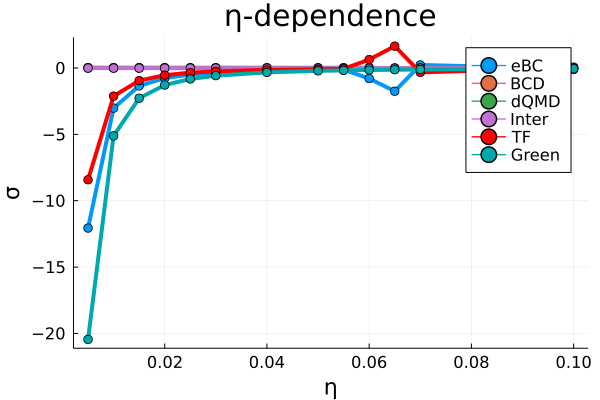

In [237]:
using Plots
using LaTeXStrings 

plot(mu0, -Drude_XXX_mu1, label="eBC",xlabel="η",ylabel="σ",title="η-dependence", width=4.0, marker=:circle, markersize = 4.8)
#plot!(mu0, sQMD_XXX_mu, label="sQMD", width=2.0, marker=:circle)
plot!(mu0, -BCD_XXX_mu1, label="BCD", width=4.0, marker=:circle, markersize = 4.8)
plot!(mu0, -sQMD_XXX_mu1-dQMD_XXX_mu1, label="dQMD", width=4.0, marker=:circle, markersize = 4.8)
plot!(mu0, -Inter_XXX_mu1, label="Inter", width=4.0, marker=:circle, markersize = 4.8)

#plot!(mu0, -dInter_XXX_mu, label="dInter", xlabel="μ",ylabel="σ",title="nonreciprocal conductivity", width=3.0, marker=:circle)
#plot!(mu0, dInter_XXX_mu1, label="dInter", width=4.0, marker=:circle, markersize = 4.8)
plot!(mu0, Green_XXX_mu1+(Drude_XXX_mu1+sQMD_XXX_mu1+BCD_XXX_mu1+dQMD_XXX_mu1+Inter_XXX_mu1+dInter_XXX_mu1), label="TF", width=4.0, marker=:circle, color=:red, markersize = 4.8)
#plot!(mu0, Green_XXX_mu+(Inter_XXX_mu), label="TF", width=2.0, marker=:circle, color=:green)
plot!(mu0, Green_XXX_mu1, label="Green", width=4.0, marker=:circle, markersize = 4.8)
#plot!(mu0, Green_XXX_sea1, label="Green_sea", width=2.0, marker=:circle, color=:orange)

In [102]:
#=
ENV["GKSwstype"]="nul"
p1=plot(mu0, DrudeX_mu, label="Drude",xlabel="T",ylabel="σ",title="linear conductivity", width=2.0, marker=:circle)
p1=plot!(mu0, BCX_mu+dQMX_mu, label="sQM", width=2.0, marker=:circle)
#p1=plot!(mu0, Green_mu-DrudeX_mu-BCX_mu-dQMX_mu, label="TF", width=2.0, marker=:circle)
#p1=plot!(mu0, Green_mu, label="Green", width=2.0, marker=:circle)
savefig(p1,"./T_dep_ZZ.png")
=#
#p2=plot(mu0, Drude_XXX_mu, label="Drude",xlabel="T",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle)
#p2=plot!(mu0, sQMD_XXX_mu, label="sQMD", width=2.0, marker=:circle)
#p2=plot!(mu0, BCD_XXX_mu, label="BCD", width=2.0, marker=:circle)
#p2=plot!(mu0, dQMD_XXX_mu, label="dQMD", width=2.0, marker=:circle)
#p2=plot!(mu0, Green_XXX_mu, label="Green", width=2.0, marker=:circle)
#savefig(p2,"./T_dep_XXX.png")
#plot(mu0, BCD_XXX_mu, label="BCD", width=2.0, marker=:circle)
#plot!(mu0, dQMD_XXX_mu+BCD_XXX_mu, label="sum_TR", width=2.0, marker=:circle)
p2=plot(mu0, Drude_XXX_mu+sQMD_XXX_mu+BCD_XXX_mu+dQMD_XXX_mu+Inter_XXX_mu+dInter_XXX_mu, label="band_sum",xlabel="T",ylabel="σ",title="NRC", width=2.0, marker=:circle)
p2=plot!(mu0, -Green_XXX_mu-(Drude_XXX_mu+sQMD_XXX_mu+BCD_XXX_mu+dQMD_XXX_mu+Inter_XXX_mu+dInter_XXX_mu), label="TF", width=2.0, marker=:circle)
p2=plot!(mu0, -Green_XXX_mu, label="Green", width=2.0, marker=:circle)
#plot!(mu0, total_XXX_mu, label="total", width=2.0, marker=:circle)
savefig(p2,"./T_dep_XXX2.png")

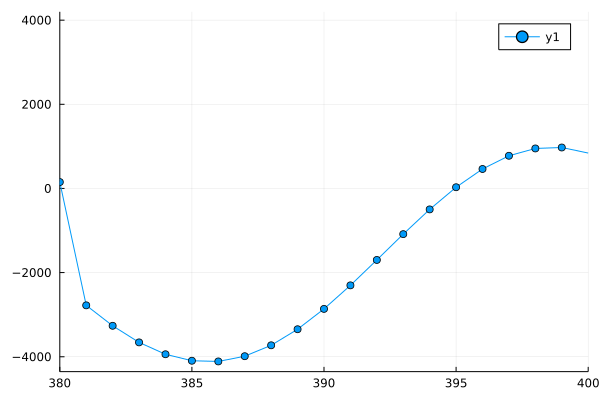

In [57]:
#ENV["GKSwstype"]="GR"
#using Plots
plot(Drude_XXX_mu, xrange=(380,400), marker=:circle)
#plot((kk[:]...,Drude_XXX_mu),st=:scatter,title="scatter",label="exp(-x)")